In [21]:
# Public libraries
import fitwrap as fw
import glob, os, sys, shutil # system packages
import matplotlib.pyplot as plt
import mpmath as mp
import nptable
import numpy as np
import pandas as pd
import pickle
import scipy.constants as const
import scipy.ndimage as ndimage
import scipy.optimize as opt
import scipy.signal as signal
import time

# Local libraries
# sys.path.append("./pyLi") # Adds pyLi directory to python modules path.
# import lithium as li
import other as ot
import mplparams

# Loading constants
a0 = const.physical_constants["Bohr radius"][0]
c = const.physical_constants["speed of light in vacuum"][0]
h = const.physical_constants["Planck constant"] [0]
hbar = h/(2*np.pi)
kB = const.physical_constants["Boltzmann constant"][0]
m = 9.9883414 * 10**(-27) # Lithium mass [Kg]
muB = const.physical_constants["Bohr magneton"][0]


# Setting inline plots in notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
if os.name == 'posix':
    %config InlineBackend.figure_format = 'retina' #retina display settings
    
# Set and create an os independent savepath
save_path = os.sep.join((os.path.expanduser("~"), "Desktop", "jupyter"))
os.makedirs(save_path, exist_ok=True)
mplc = plt.rcParams['axes.prop_cycle'].by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To make a mp4 movie:

*ffmpeg -r 30 -f image2 -s 432x288 -i pic%05d.png -vcodec libx264 -crf 5  -pix_fmt yuv420p test.mp4*

In [22]:
# colors
c1 = '#ff3e30'
c2 = '#db3236'
c2 = '#4885ed'
c12 = 'yellow'
cmol = 'black'


from matplotlib import colors
cmap = colors.ListedColormap(['white', c1, c2, c12, cmol])
bounds=[-0.5,0.5,1.5,2.5,3.5,4.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [23]:
class State(object):
    def __init__(self, initial_state, initial_temperature, initial_kfa):
        self.T = initial_temperature
        self.state = initial_state
        self.kFa = initial_kfa
        self.SIZE = initial_state.shape[0]
        
        self.N_tot = np.sum(self.state==1) + np.sum(self.state==2) + 2*np.sum(self.state==3) + 2*np.sum(self.state==4)

        self.VUOTO = 0
        self.ATOMO_1 = 0
        self.ATOMO_2 = 0
    
        # trap potential weights
        self.on_site_potential = {
                    0 : 0,
                    1 : 1,
                    2 : 1,
                    3 : 2,
                    4 : 2
                    }

    def MOLECOLA(self):
        return -2/self.kFa**2

    def DOPPIO(self):
        return self.atom_atom_energy()*4

    def ATOMOa_ATOMOa(self):
        return (3/5)

    def ATOMOa_ATOMOb(self):
        return (self.atom_atom_energy())

    def MOLECOLA_ATOMO(self):
        return (0.9 * self.atom_atom_energy())

    def MOLECOLA_MOLECOLA(self):
        return (0.6 * self.atom_atom_energy())

    def DOPPIO_ATOMO(self):
        return (3/5 + self.atom_atom_energy())

    def DOPPIO_DOPPIO(self):
        return (6/5 + self.atom_atom_energy())

    def DOPPIO_MOLECOLA(self):
        return (1.8*self.atom_atom_energy())

    def roll_state(self, i, j):
        return i % self.SIZE, j % self.SIZE


    def chose_random_sites(self):
        i, j = np.random.randint(self.SIZE, size=2)
        direction = np.random.randint(4)
        sites = np.zeros((8, 2), dtype='int16')

        if direction==0:
            sites[0] = self.roll_state(i,j)
            sites[1] = self.roll_state(i,j+1)

            sites[2] = self.roll_state(i+1,j)
            sites[3] = self.roll_state(i,j-1)
            sites[4] = self.roll_state(i-1,j)

            sites[5] = self.roll_state(i,j+2)
            sites[6] = self.roll_state(i+1,j+1)
            sites[7] = self.roll_state(i-1,j+1)

        elif direction==1:
            sites[0] = self.roll_state(i,j)
            sites[1] = self.roll_state(i+1,j)

            sites[2] = self.roll_state(i,j-1)
            sites[3] = self.roll_state(i-1,j)
            sites[4] = self.roll_state(i,j+1)

            sites[5] = self.roll_state(i+2,j)
            sites[6] = self.roll_state(i+1,j-1)
            sites[7] = self.roll_state(i+1,j+1)

        elif direction==2:
            sites[0] = self.roll_state(i,j)
            sites[1] = self.roll_state(i,j-1)

            sites[2] = self.roll_state(i+1,j)
            sites[3] = self.roll_state(i,j+1)
            sites[4] = self.roll_state(i-1,j)

            sites[5] = self.roll_state(i,j-2)
            sites[6] = self.roll_state(i+1,j-1)
            sites[7] = self.roll_state(i-1,j-1)

        elif direction==3:
            sites[0] = self.roll_state(i,j)
            sites[1] = self.roll_state(i-1,j)

            sites[2] = self.roll_state(i,j-1)
            sites[3] = self.roll_state(i+1,j)
            sites[4] = self.roll_state(i,j+1)

            sites[5] = self.roll_state(i-2,j)
            sites[6] = self.roll_state(i-1,j-1)
            sites[7] = self.roll_state(i-1,j+1)

        return sites
    
    def on_site(self, state_in_site):
        if state_in_site == 0:
            return self.VUOTO

        elif state_in_site == 1:
            return self.ATOMO_1

        elif state_in_site == 2:
            return self.ATOMO_2

        elif state_in_site == 3:
            return self.DOPPIO()

        elif state_in_site == 4:
            return self.MOLECOLA()


    def swap_states(self, s, final):
        self.state[s[0, 0], s[0, 1]] = final[0]
        self.state[s[1, 0], s[1, 1]] = final[1]

    
    def off_site(self, a, b):
        if (a==0) or (b==0):
            return 0
        
        if a==1:
            if b==1:
                return self.ATOMOa_ATOMOa()
            elif b==2:
                return self.ATOMOa_ATOMOb()
            elif b==3:
                return self.DOPPIO_ATOMO()
            elif b==4:
                return self.MOLECOLA_ATOMO()
            
        if a==2:
            if b==1:
                return self.ATOMOa_ATOMOb()
            elif b==2:
                return self.ATOMOa_ATOMOa()
            elif b==3:
                return self.DOPPIO_ATOMO()
            elif b==4:
                return self.MOLECOLA_ATOMO()
            
        if a==3:
            if b==1:
                return self.DOPPIO_ATOMO()
            elif b==2:
                return self.DOPPIO_ATOMO()
            elif b==3:
                return self.DOPPIO_DOPPIO()
            elif b==4:
                return self.DOPPIO_MOLECOLA()
            
        if a==4:
            if b==1:
                return self.MOLECOLA_ATOMO()
            elif b==2:
                return self.MOLECOLA_ATOMO()
            elif b==3:
                return self.DOPPIO_MOLECOLA()
            elif b==4:
                return self.MOLECOLA_MOLECOLA()
        
        
    def d_energy(self, i, f):
        
        # on site
        de = self.on_site(f[0]) + self.on_site(f[1]) - self.on_site(i[0]) - self.on_site(i[1])
        
        # nearest sites
        de = de + self.off_site(f[0], f[1])
        de = de + sum([self.off_site(f[0], f[x+2]) for x in range(3)])
        de = de + sum([self.off_site(f[1], f[x+5]) for x in range(3)])
        
        de = de - self.off_site(i[0], i[1])
        de = de - sum([self.off_site(i[0], i[x+2]) for x in range(3)])
        de = de - sum([self.off_site(i[1], i[x+5]) for x in range(3)])
            
        return de

    def simple_swap(self, s):
        initial = [self.state[s[i, 0], s[i,1]] for i in range(8)]
        final = initial[:]
        final[0], final[1] = final[1], final[0]
        return initial, final

    def trap(self, i, j):
        return (i-self.SIZE/2)**2/(self.SIZE/2)**2

    def trapping_potential(self, s, i, f):
        i_pot = self.on_site_potential[i[0]]*self.trap(s[0, 0], s[0, 1]) + self.on_site_potential[i[1]]*self.trap(s[1, 0], s[1, 1])
        f_pot = self.on_site_potential[f[0]]*self.trap(s[0, 0], s[0, 1]) + self.on_site_potential[f[1]]*self.trap(s[1, 0], s[1, 1])
        return f_pot-i_pot

    def energy_spectrum(self, state):
        pass


    def metropolis_step(self):
        s = self.chose_random_sites()
        n_mol_created = 0
        
        initial = [self.state[s[i, 0], s[i,1]] for i in range(8)]
        final = initial[:]
        
        # first site is empty
        if self.state[s[0,0], s[0,1]] == 0:
            if self.state[s[1,0], s[1,1]] == 0: #second empty
                pass
            elif self.state[s[1,0], s[1,1]] != 3: #second atom 1 or 2 or molecule
                final[0], final[1] = final[1], final[0]            
            else: #second site double
                option = np.random.randint(3)
                if option==0: #simple swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: #atom 1 fills the empty
                    final[0], final[1] = 1, 2
                elif option==2: #atom 2 fills the empty
                    final[0], final[1] = 2, 1

                
        # first site atom 1
        elif self.state[s[0,0], s[0,1]] == 1:
            if self.state[s[1,0], s[1,1]] == 0: #second empty
                final[0], final[1] = final[1], final[0]
            elif self.state[s[1,0], s[1,1]] == 1: #second atom 1
                pass
            elif self.state[s[1,0], s[1,1]] == 2: #second atom 2
                option = np.random.randint(3)
                if option==0: #simple swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: #double creation
                    final[0], final[1] = 0, 3        
                elif option==2: #molecular creation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 0, 4
                        n_mol_created = 1
            elif self.state[s[1,0], s[1,1]] == 3: #second double
                option = np.random.randint(2)
                if option==0: # molecule creation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 1, 4
                        n_mol_created = 1
                elif option==1: #swap
                    final[0], final[1] = final[1], final[0]
            elif self.state[s[1,0], s[1,1]] == 4: #second molecule
                option = np.random.randint(2)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # molecule dissociation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 1, 3
                        n_mol_created = -1
                    
                    
        # first site atom 2
        elif self.state[s[0,0], s[0,1]] == 2:
            if self.state[s[1,0], s[1,1]] == 0: #second empty
                final[0], final[1] = final[1], final[0]
            elif self.state[s[1,0], s[1,1]] == 1: #second atom 1
                option = np.random.randint(3)
                if option==0: #simple swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: #double creation
                    final[0], final[1] = 0, 3  
                elif option==2: #molecular creation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 0, 4
                        n_mol_created = 1
            elif self.state[s[1,0], s[1,1]] == 2: #second atom 2
                pass
            elif self.state[s[1,0], s[1,1]] == 3: #second double
                option = np.random.randint(2)
                if option==0: # molecule creation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 2, 4
                        n_mol_created = 1
                elif option==1: #swap
                    final[0], final[1] = final[1], final[0]
            elif self.state[s[1,0], s[1,1]] == 4: #second molecule
                option = np.random.randint(2)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # molecule dissociation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 2, 3
                        n_mol_created = -1
                    

        # first site double
        elif self.state[s[0,0], s[0,1]] == 3:
            if self.state[s[1,0], s[1,1]] == 0: #second empty
                option = np.random.randint(3)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # atom split 1 initial
                    final[0], final[1] = 1, 2
                elif option==2: # atom split 2 initial
                    final[0], final[1] = 2, 1
            elif self.state[s[1,0], s[1,1]] == 1: #second atom 1
                option = np.random.randint(2)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # molecular creation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 1, 4
                        n_mol_created = 1
            elif self.state[s[1,0], s[1,1]] == 2: #second atom 2
                option = np.random.randint(2)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # molecular creation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 2, 4
                        n_mol_created = 1
            elif self.state[s[1,0], s[1,1]] == 3: #second double
                option = np.random.randint(3)
                if np.random.random()<self.franck_condon():
                    if option==0: # molecule molecule
                        final[0], final[1] = 4, 4
                        n_mol_created = 2
                    elif option==1: # molecule double
                        final[0], final[1] = 4, 3
                        n_mol_created = 1
                    elif option==2: # double molecule
                        final[0], final[1] = 3, 4
                        n_mol_created = 1
            elif self.state[s[1,0], s[1,1]] == 4: #second molecule
                option = np.random.randint(3)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # molecule molecule
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 4, 4
                        n_mol_created = 1
                elif option==2: # double double
                    final[0], final[1] = 3, 3
                    n_mol_created = -1
                    
                    
        # first site molecule
        elif self.state[s[0,0], s[0,1]] == 4:
            if self.state[s[1,0], s[1,1]] == 0: #second empty
                final[0], final[1] = final[1], final[0] #swap
            elif self.state[s[1,0], s[1,1]] == 1: #second atom 1
                option = np.random.randint(2)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # dissociation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 3, 1
                        n_mol_created = -1
            elif self.state[s[1,0], s[1,1]] == 2: #second atom 2
                option = np.random.randint(2)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # dissociation
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 3, 2
                        n_mol_created = -1
            elif self.state[s[1,0], s[1,1]] == 3: #second double
                option = np.random.randint(3)
                if option==0: # swap
                    final[0], final[1] = final[1], final[0]
                elif option==1: # molecule molecule
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 4, 4
                elif option==2: # double double
                    final[0], final[1] = 3, 3
                    n_mol_created = -1
            elif self.state[s[1,0], s[1,1]] == 4: #second molecule
                option = np.random.randint(3)
                if option==0: # double doble
                    final[0], final[1] = 3, 3
                    n_mol_created = -2
                elif option==1: # molecule double
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 4, 3
                        n_mol_created = -1
                elif option==2: # double molecule
                    if np.random.random()<self.franck_condon():
                        final[0], final[1] = 3, 4
                        n_mol_created = -1

        de = self.d_energy(initial, final)
        de = de + self.trapping_potential(s, initial, final)*10
        if de<=0:
            self.swap_states(s, final)
            self.T = self.T - self.MOLECOLA() * n_mol_created / self.N_tot
        else:
            if np.random.random() < np.exp(-de/self.T):
                self.swap_states(s, final)
                self.T = self.T - self.MOLECOLA() * n_mol_created / self.N_tot
            

    def franck_condon(self):
        return 0.289*148/(6*np.pi**2)**2 * self.kFa**6 / (1+0.5*self.kFa**2)

    def atom_atom_energy(self):
        return 4/(3*np.pi)*self.kFa + 2/np.pi**2 * self.kFa**2


In [24]:
SIZE = 50
np.random.seed(42)

xx = np.arange(SIZE)
trappola = 1-(xx-SIZE/2)**2/(SIZE/2)**2
t1 = (np.random.random(size=(SIZE, SIZE))<(np.ones(shape=(SIZE,SIZE))*trappola[:,None])).astype('int16')
t2 = (np.random.random(size=(SIZE, SIZE))<(np.ones(shape=(SIZE,SIZE))*trappola[:,None])).astype('int16')

state_1 = np.random.choice([0,1,1,1], size=(SIZE,SIZE)).astype('int16')*t1
state_2 = np.random.choice([0,2,2,2], size=(SIZE,SIZE)).astype('int16')*t2
initial_state = state_1+state_2

state = State(initial_state, initial_kfa=0.01, initial_temperature=0.1)

[##################################################] 100.0%

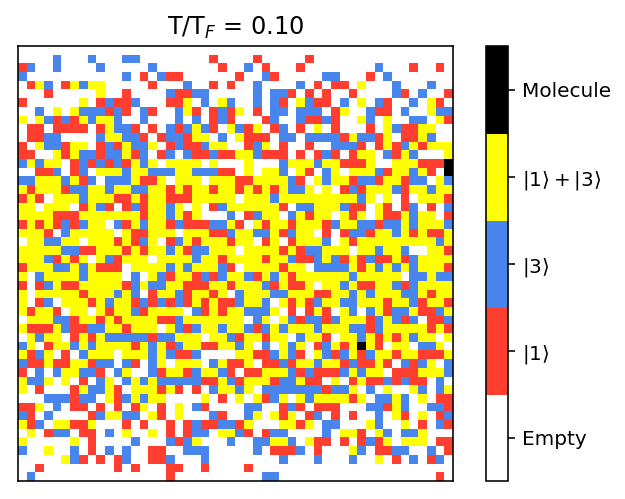

In [25]:
np.random.seed(42)
TOTAL_STEPS = int(1e2)
state.kFa = 1.4
# state.T = -1

for index in range(100):
    for i in range(TOTAL_STEPS//100):
        state.metropolis_step()
    ot.progress_bar(index, 100)

fig, ax = plt.subplots(1)
img = ax.imshow(state.state, cmap=cmap, norm=norm)
cbar = fig.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3, 4])
cbar.ax.set_yticklabels(['Empty', r'$|1\rangle$', r'$|3\rangle$', r'$|1\rangle+|3\rangle$', 'Molecule']);
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_title('T/T$_F$ = {:.2f}'.format(state.T));

[##################################################] 100.0%

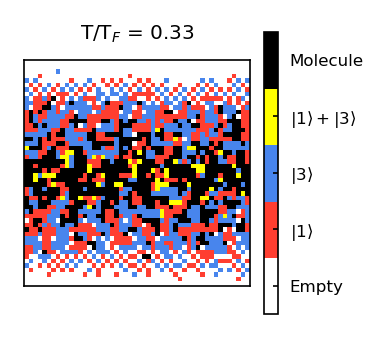

In [26]:
# preparation
np.random.seed(42)
SIZE = 50

xx = np.arange(SIZE)
trappola = 1-(xx-SIZE/2)**2/(SIZE/2)**2
t1 = (np.random.random(size=(SIZE, SIZE))<(np.ones(shape=(SIZE,SIZE))*trappola[:,None])).astype('int16')
t2 = (np.random.random(size=(SIZE, SIZE))<(np.ones(shape=(SIZE,SIZE))*trappola[:,None])).astype('int16')

state_1 = np.random.choice([0,1,1,1], size=(SIZE,SIZE)).astype('int16')*t1
state_2 = np.random.choice([0,2,2,2], size=(SIZE,SIZE)).astype('int16')*t2
initial_state = state_1+state_2

state = State(initial_state, initial_kfa=0.01, initial_temperature=0.1)

TOTAL_STEPS = int(3e5)
for index in range(100):
    for i in range(TOTAL_STEPS//100):
        state.metropolis_step()
    ot.progress_bar(index, 100)

    
    

state.T=-1
TOTAL_STEPS = int(1e2)
for index in range(100):
    for i in range(TOTAL_STEPS//100):
        state.metropolis_step()
    ot.progress_bar(index, 100)
state.T=0.1

with plt.rc_context(mplparams.single_column):
    fig = plt.figure(figsize=[s/25.5 for s in (30,30)], dpi=120)  # pdi of the screen to show
                                                                  # the real size of the plot
    ax = fig.add_axes([0,0,1,1]) # set the axes to be the full size of the figure
    cbar = fig.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3, 4])
    cbar.ax.set_yticklabels(['Empty', r'$|1\rangle$', r'$|3\rangle$', r'$|1\rangle+|3\rangle$', 'Molecule']);
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    TOTAL_STEPS = int(1e5)
    state.kFa = 1.4
    for index in range(100):
        img = ax.imshow(state.state, cmap=cmap, norm=norm)
        ax.set_title('T/T$_F$ = {:.2f}'.format(state.T))
        fig.savefig(save_path + '/mc/initial_{}.pdf'.format(index), bbox_inches="tight")
        for i in range(TOTAL_STEPS//100):
            state.metropolis_step()
        ot.progress_bar(index, 100)

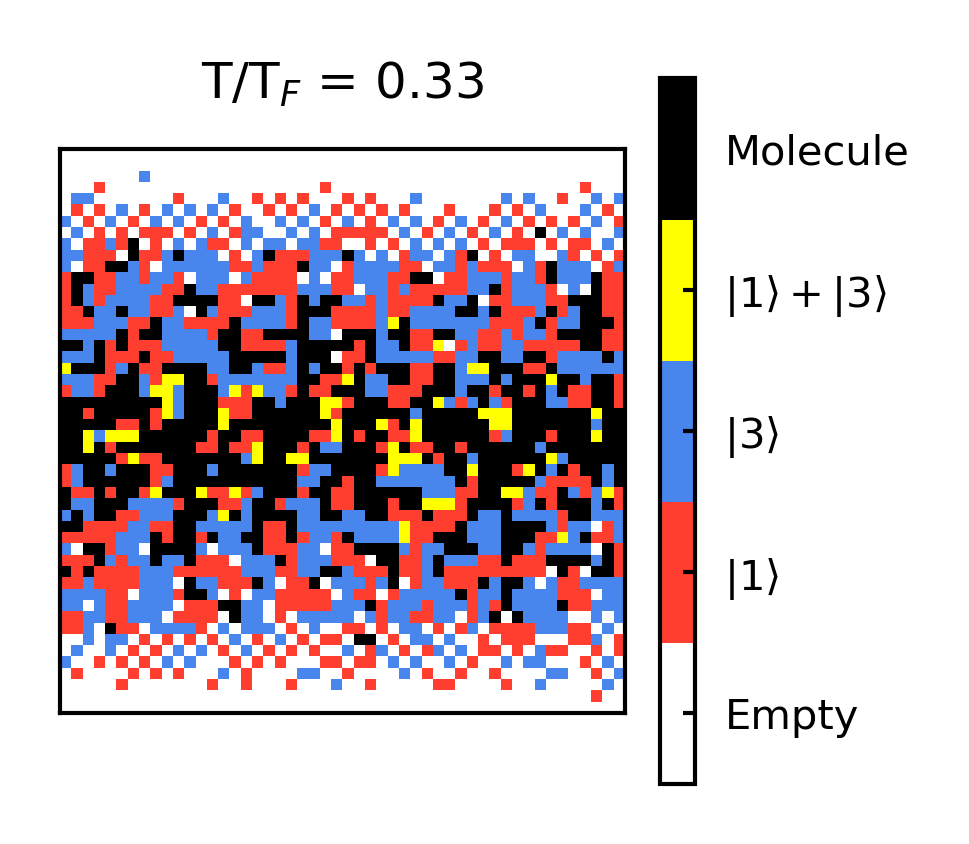

In [27]:
with plt.rc_context(mplparams.single_column):
        fig = plt.figure(figsize=[s/25.5 for s in (30,30)], dpi=300)  # pdi of the screen to show
                                                                      # the real size of the plot
        ax = fig.add_axes([0,0,1,1]) # set the axes to be the full size of the figure
        img = ax.imshow(state.state, cmap=cmap, norm=norm)
        cbar = fig.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1, 2, 3, 4])
        cbar.ax.set_yticklabels(['Empty', r'$|1\rangle$', r'$|3\rangle$', r'$|1\rangle+|3\rangle$', 'Molecule']);
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title('T/T$_F$ = {:.2f}'.format(state.T))